<a href="https://colab.research.google.com/github/theabhinav0231/dive_into_deep_learning_book/blob/main/03_Linear_Neural_Networks_for_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Regression problems pop up whenever we want to predict a numerical value. Ex: predicting prices(house, stocks), predicting the length of stay(a patient in a hospital), forecasting demand.

In [2]:
!pip install d2l

In [8]:
%matplotlib inline
import math
import time
import numpy as np
import torch
import torch.nn as nn
from d2l import torch as d2l

The key technique for optimizing nearly every deep learning model, and which we will
call upon throughout this book, consists of iteratively reducing the error by updating the
parameters in the direction that incrementally lowers the loss function. This algorithm is
called gradient descent.

The other extreme is to consider only a single example at a time and to take update steps
based on one observation at a time. The resulting algorithm, stochastic gradient descent
(SGD) can be an effective strategy (Bottou, 2010), even for large datasets. Unfortunately,
SGD has drawbacks, both computational and statistical. One problem arises from the fact
that processors are a lot faster multiplying and adding numbers than they are at moving data
from main memory to processor cache. It is up to an order of magnitude more efficient
to perform a matrix–vector multiplication than a corresponding number of vector–vector
operations. This means that it can take a lot longer to process one sample at a time compared
to a full batch. A second problem is that some of the layers, such as batch normalization
(to be described in Section 8.5), only work well when we have access to more than one
observation at a time.
The solution to both problems is to pick an intermediate strategy: rather than taking a full
batch or only a single sample at a time, we take a minibatch of observations (Li et al., 2014).
The specific choice of the size of the said minibatch depends on many factors, such as the
amount of memory, the number of accelerators, the choice of layers, and the total dataset
size. Despite all that, a number between 32 and 256, preferably a multiple of a large power
of 2, is a good start. This leads us to minibatch stochastic gradient descent.

In [6]:
class HyperParameters:
  """The base class of hyperparameters."""
  def save_hyperparameters(self, ignore=[]):
    raise NotImplemented

In [5]:
class ProgressBoard(d2l.HyperParameters):
  """The board that plots data points in animation."""
  def __init__(self, xlabel=None, ylabel=None, xlim=None,
              ylim=None, xscale='linear', yscale='linear',
              ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
              fig=None, axes=None, figsize=(3.5, 2.5), display=True):
    self.save_hyperparameters()
    def draw(self, x, y, label, every_n=1):
      raise NotImplemented

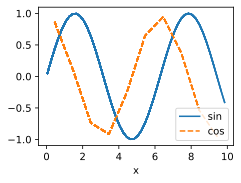

In [7]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
  board.draw(x, np.sin(x), 'sin', every_n=2)
  board.draw(x, np.cos(x), 'cos', every_n=10)

**MODEL**

The Module class is the base class of all models we will implement. At the very least
we need three methods. The first, __init__, stores the learnable parameters, the training_
step method accepts a data batch to return the loss value, and finally, configure_optimizers
returns the optimization method, or a list of them, that is used to update the learnable parameters.

In [9]:
class Module(nn.Module, d2l.HyperParameters):
  """The base class of models."""
  def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
    super().__init__()
    self.save_hyperparameters()
    self.board = ProgressBoard()
  def loss(self, y_hat, y):
    raise NotImplementedError
  def forward(self, X):
    assert hasattr(self, 'net'), 'Neural network is defined'
    return self.net(X)
  def plot(self, key, value, train):
    """Plot a point in animation."""
    assert hasattr(self, 'trainer'), 'Trainer is not inited'
    self.board.xlabel = 'epoch'
    if train:
      x = self.trainer.train_batch_idx / \
          self.trainer.num_train_batches
      n = self.trainer.num_train_batches / \
          self.plot_train_per_epoch
    else:
      x = self.trainer.epoch + 1
      n = self.trainer.num_val_batches / \
          self.plot_valid_per_epoch
    self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                  ('train_' if train else 'val_') + key,
                  every_n=int(n))
    def training_step(self, batch):
      l = self.loss(self(*batch[:-1]), batch[-1])
      self.plot('loss', l, train=True)
      return l
    def validation_step(self, batch):
      l = self.loss(self(*batch[:-1]), batch[-1])
      self.plot('loss', l, train=False)
    def configure_optimizers(self):
      raise NotImplementedError

**DATA**

The DataModule class is the base class for data. Quite frequently the __init__ method is
used to prepare the data. This includes downloading and preprocessing if needed. The
train_dataloader returns the data loader for the training dataset. A data loader is a
(Python) generator that yields a data batch each time it is used. This batch is then fed
into the training_step method of Module to compute the loss. There is an optional
val_dataloader to return the validation dataset loader. It behaves in the same manner,
except that it yields data batches for the validation_step method in Module.

In [10]:
class DataModule(d2l.HyperParameters):
  """The base class of data."""
  def __init__(self, root='../data', num_workers=4):
    self.save_hyperparameters()
  def get_dataloader(self, train):
    raise NotImplementedError
  def train_dataloader(self):
    return self.get_dataloader(train=True)
  def val_dataloader(self):
    return self.get_dataloader(train=False)

**TRAINING**
The Trainer class trains the learnable parameters in the Module class with data specified
in DataModule. The key method is fit, which accepts two arguments: model, an instance
of Module, and data, an instance of DataModule. It then iterates over the entire dataset max_epochs times to train the model.

In [11]:
class Trainer(d2l.HyperParameters):
  """The base class for training models with data."""
  def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    assert num_gpus == 0, 'No GPU support yet'
  def prepare_data(self, data):
    self.train_dataloader = data.train_dataloader()
    self.val_dataloader = data.val_dataloader()
    self.num_train_batches = len(self.train_dataloader)
    self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)
  def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    self.model = model
  def fit(self, model, data):
    self.prepare_data(data)
    self.prepare_model(model)
    self.optim = model.configure_optimizers()
    self.epoch = 0
    self.train_batch_idx = 0
    self.val_batch_idx = 0
    for self.epoch in range(self.max_epochs):
      self.fit_epoch()
  def fit_epoch(self):
    raise NotImplementedError